# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#for parameter scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, average_precision_score




---
## 2. Load data

In [2]:
df = pd.read_csv(r'C:\Users\NAMEERA\Desktop\BCG customer churn ML/clean_data_after_eda.csv',index_col=0)
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df= pd.read_csv(r'C:\Users\NAMEERA\Downloads\price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
diff.describe()


,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
count,16096.000000,16096.000000
mean,-0.004545,0.279544
std,0.012778,1.432820
min,-0.148477,-44.266931
25%,-0.008161,0.000004
50%,-0.005610,0.162916
75%,-0.003573,0.177779
max,0.168958,40.728885


In [7]:
diff.shape

(16096, 3)

In [8]:
type(diff)

pandas.core.frame.DataFrame

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14605 non-null  object        
 1   channel_sales                   14605 non-null  object        
 2   cons_12m                        14605 non-null  int64         
 3   cons_gas_12m                    14605 non-null  int64         
 4   cons_last_month                 14605 non-null  int64         
 5   date_activ                      14605 non-null  datetime64[ns]
 6   date_end                        14605 non-null  datetime64[ns]
 7   date_modif_prod                 14605 non-null  datetime64[ns]
 8   date_renewal                    14605 non-null  datetime64[ns]
 9   forecast_cons_12m               14605 non-null  float64       
 10  forecast_cons_year              14605 non-null  int64         
 11  fo

C:\Users\NAMEERA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='offpeak_diff_dec_january_energy', ylabel='Density'>

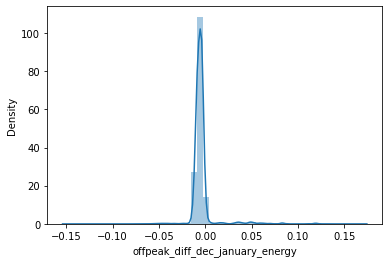

In [10]:
sns.distplot(diff['offpeak_diff_dec_january_energy'])

C:\Users\NAMEERA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='offpeak_diff_dec_january_power', ylabel='Density'>

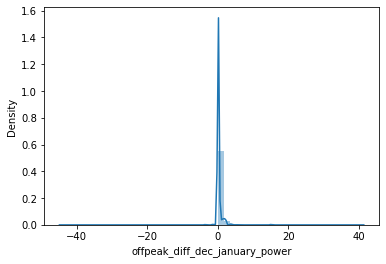

In [11]:
sns.distplot(diff['offpeak_diff_dec_january_power'])

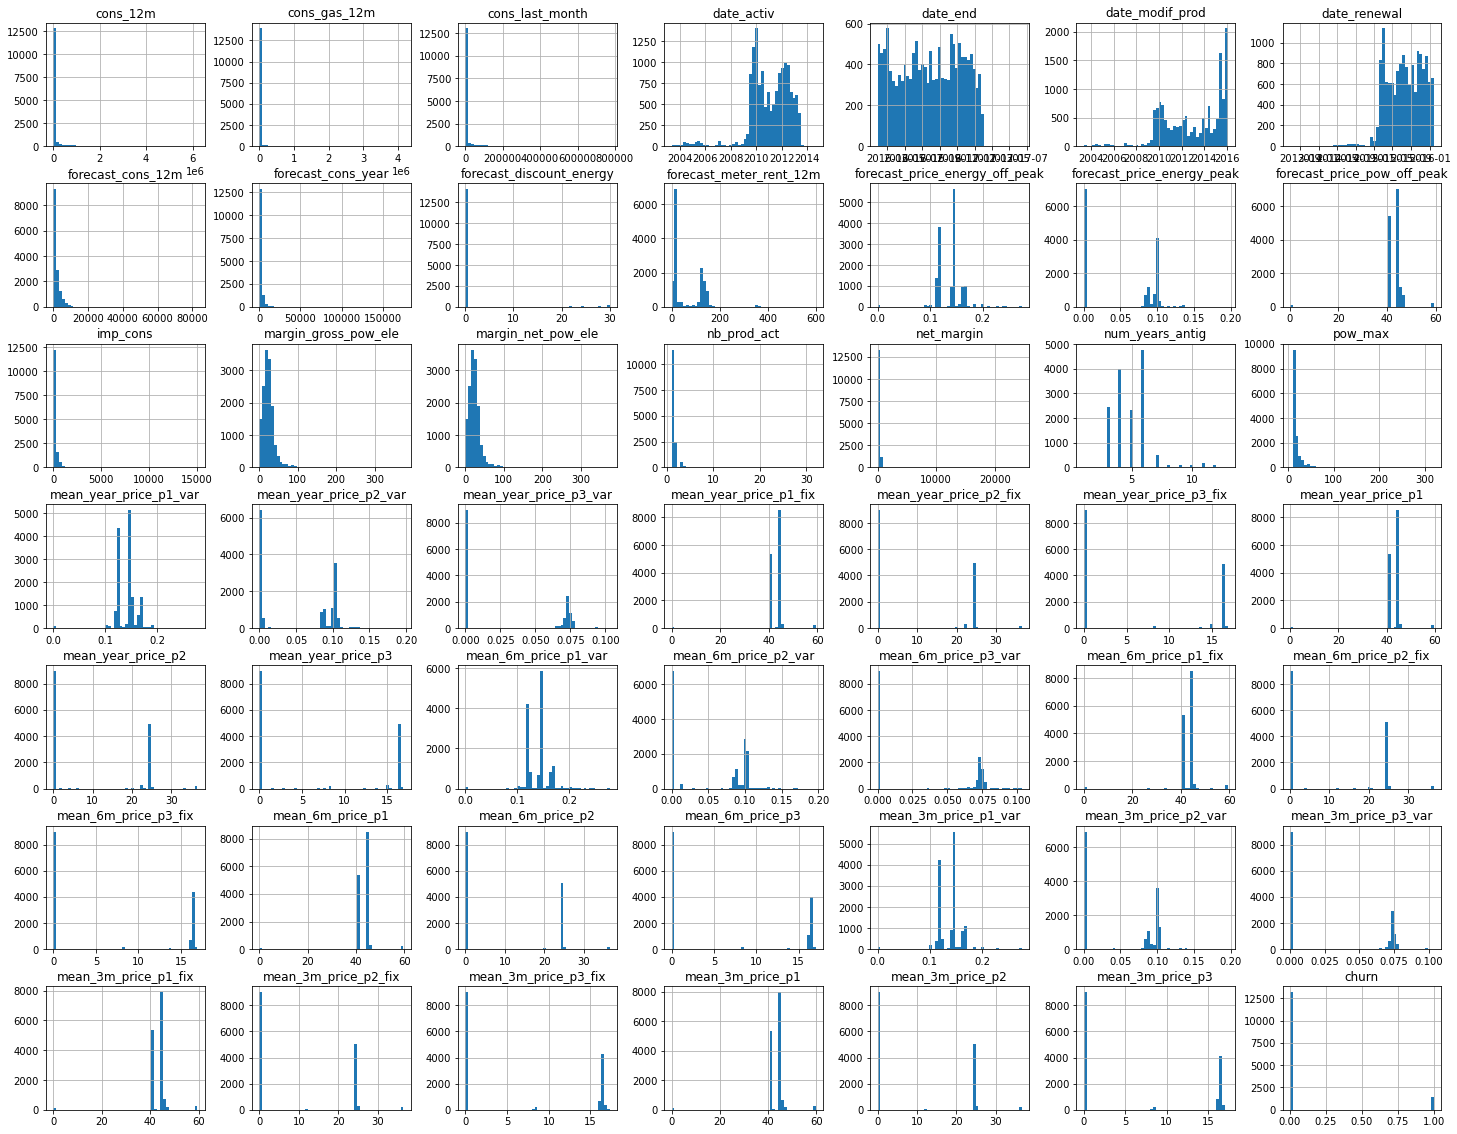

In [12]:
df.hist(figsize=(25,20),bins=50)
plt.show()

In [13]:
churn = df[['id','churn']]

In [14]:
diff_churn=pd.merge(diff,churn,on='id')
diff_churn.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,churn
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,0
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0
3,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0
4,0013f326a839a2f6ad87a1859952d227,-0.006171,0.000000,0


In [15]:
correlation = diff_churn.corr()

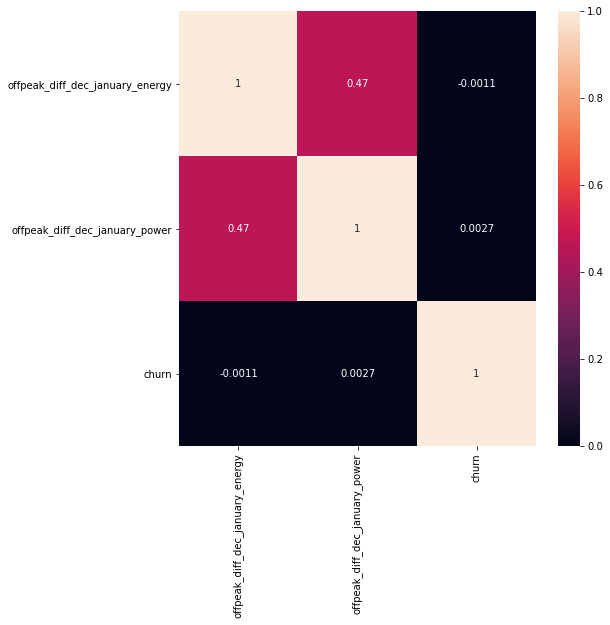

In [16]:
plt.figure(figsize=(8,8))
sns.heatmap(correlation,xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, annot = True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

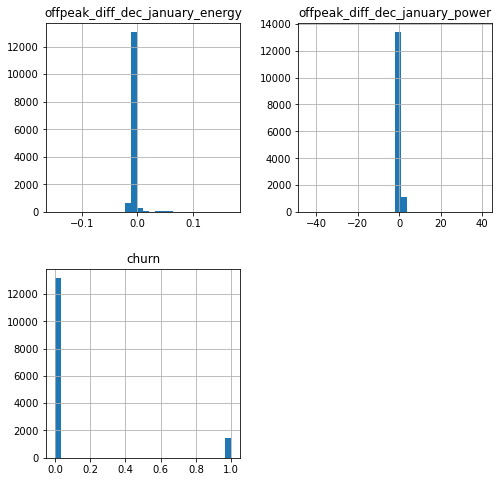

In [17]:
diff_churn.hist(figsize=(8,8),bins=30)
plt.show()

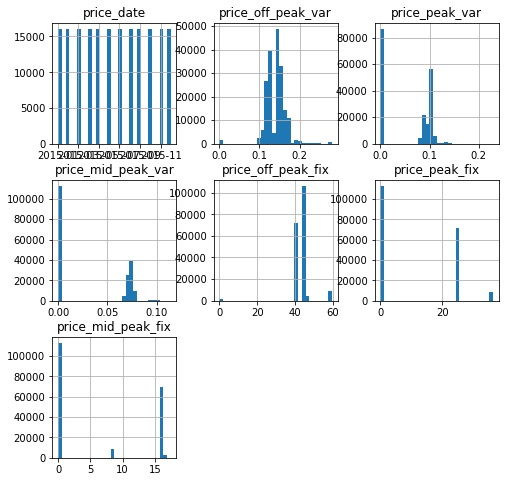

In [18]:
price_df.hist(figsize=(8,8),bins=30)
plt.show()

In [19]:
select = RandomForestClassifier(n_estimators=1000, random_state=42)

In [20]:
xgbc = XGBClassifier() 

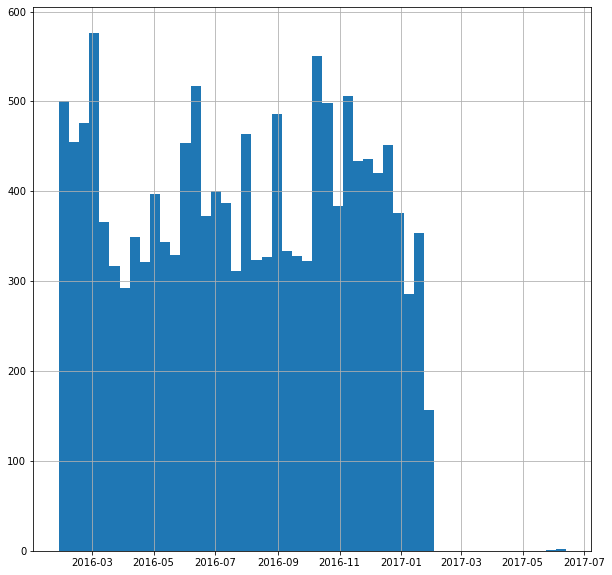

In [21]:
df['date_end'].hist(figsize=(10,10),bins=50)
plt.show()

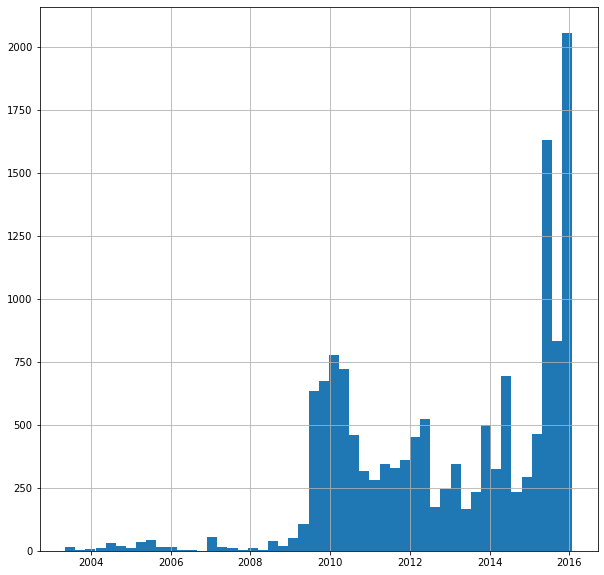

In [22]:
df['date_modif_prod'].hist(figsize=(10,10),bins=50)
plt.show()

# Difference in prices for consecutive periods

The features used should be improved for the model to predict a reliable outcome.

The plots above display the count of the change in product and end of product. It is evident that the count for end in

In [23]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


In [24]:
mean_price = price_df.groupby(['id','price_date']).agg({'price_off_peak_var':'mean','price_peak_var':'mean','price_mid_peak_var':'mean','price_off_peak_fix':'mean','price_peak_fix':'mean','price_mid_peak_fix':'mean'}).reset_index()

In [25]:
mean_price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555


In [26]:
mean_price.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [27]:
#to calculate the difference between the mean of consecutive months
mean_price['off_peak_peak_var_diff']= mean_price['price_off_peak_var']-mean_price['price_peak_var']
mean_price['peak_mid_peak_var_diff']= mean_price['price_peak_var']-mean_price['price_mid_peak_var']
mean_price['off_peak_mid_peak_var_diff']= mean_price['price_off_peak_var']-mean_price['price_mid_peak_var']
mean_price['off_peak_peak_fix_diff']= mean_price['price_off_peak_fix']-mean_price['price_peak_fix']
mean_price['peak_mid_peak_fix_diff']= mean_price['price_peak_fix']-mean_price['price_mid_peak_fix']
mean_price['off_peak_mid_peak_fix']= mean_price['price_off_peak_fix']-mean_price['price_mid_peak_fix']

In [28]:
mean_price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,off_peak_peak_var_diff,peak_mid_peak_var_diff,off_peak_mid_peak_var_diff,off_peak_peak_fix_diff,peak_mid_peak_fix_diff,off_peak_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330


In [29]:
#to find the max difference in price for each month

max_diff_across_periods_months = mean_price.groupby(['id']).agg({
    'off_peak_peak_var_diff':'max',
    'peak_mid_peak_var_diff':'max',
    'off_peak_mid_peak_var_diff':'max',
    'off_peak_peak_fix_diff':'max',
    'peak_mid_peak_fix_diff':'max',
    'off_peak_mid_peak_fix':'max'
    
}).reset_index().rename(columns={
     'off_peak_peak_var_diff':'off_peak_peak_var_max_diff',
    'peak_mid_peak_var_diff':'peak_mid_peak_var_max_diff',
    'off_peak_mid_peak_var_diff':'off_peak_mid_peak_var_max_diff',
    'off_peak_peak_fix_diff':'off_peak_peak_fix_max_diff',
    'peak_mid_peak_fix_diff':'peak_mid_peak_fix_max_diff',
    'off_peak_mid_peak_fix':'off_peak_mid_peak_max_fix'
})

In [30]:
max_diff_across_periods_months.head()

,id,off_peak_peak_var_max_diff,peak_mid_peak_var_max_diff,off_peak_mid_peak_var_max_diff,off_peak_peak_fix_max_diff,peak_mid_peak_fix_max_diff,off_peak_mid_peak_max_fix
0,0002203ffbb812588b632b9e628cc38d,0.022225,0.033743,0.055866,16.291555,8.145775,24.437330
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.000000,0.148405,44.444710,0.000000,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.000000,0.205742,45.944710,0.000000,45.944710
3,0010ee3855fdea87602a5b7aba8e42de,0.022581,0.031859,0.054440,16.291555,8.145775,24.437330
4,00114d74e963e47177db89bc70108537,0.149902,0.000000,0.149902,44.266931,0.000000,44.266931


In [31]:
columns=['id',
        'off_peak_peak_var_max_diff',
        'peak_mid_peak_var_max_diff',
        'off_peak_mid_peak_var_max_diff',
        'off_peak_peak_fix_max_diff',
        'peak_mid_peak_fix_max_diff',
        'off_peak_mid_peak_max_fix']
df= pd.merge(df,max_diff_across_periods_months[columns],on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,off_peak_peak_var_max_diff,peak_mid_peak_var_max_diff,off_peak_mid_peak_var_max_diff,off_peak_peak_fix_max_diff,peak_mid_peak_fix_max_diff,off_peak_mid_peak_max_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,42.629663,12.311304,8.182687,1,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,44.592310,0.000000,0.000000,0,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,44.612508,0.088409,0.000000,0,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,44.593296,0.000000,0.000000,0,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,40.848791,24.539003,16.365274,0,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


In [32]:
df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
       'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
       'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
       'mea

# EDA to model the features 

From the previous attempt at modelling the features above, it is imperative that the features needed are more specific than just a vague dataframe of difference in prices. 

In [33]:
#To calculate the tenure by using timedelta
from datetime import timedelta
df['tenure']=(df['date_end']-df['date_activ'])

In [34]:
df['tenure']=(df['tenure']/np.timedelta64(1,'Y')).astype('int')
df['tenure']

0        3
1        7
2        6
3        6
4        6
        ..
14600    3
14601    4
14602    3
14603    4
14604    6
Name: tenure, Length: 14605, dtype: int32

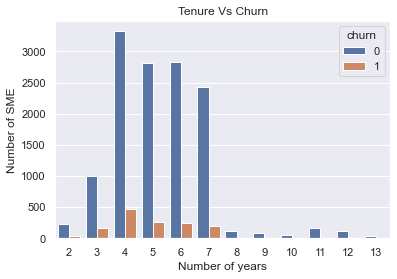

In [35]:
#visualise churn vs tenure
sns.set()
plt.figure()
ax= sns.countplot(x=df['tenure'],hue=df['churn'])
ax.set_title('Tenure Vs Churn')
ax.set_ylabel('Number of SME')
ax.set_xlabel('Number of years')
plt.show()

As mentioned earlier during the exploratory data analysis, the plot shows that the highest number of customers who've churned have had a tenure of 5 years or less. The number of clients with 2 years tenure is relatively lesser perhaps due to obvious reasons, i.e, because they're new to the company and their policies, hence, testing the waters. Customers with a tenure more than 7 years display no attrition, this could also be due to the loyalty and familiarity with the company and its history. 

This evidence could be one of the factors to decide the customers who could possibly receive discounts to retain.

In [36]:
#Number of months left to renew contract
# Jan 2016 is used as the reference date since the customers had churned during the beginning of 2016
from datetime import datetime
df['months_since_modif'] =  ((datetime(2016,1,1)-df['date_modif_prod'])/np.timedelta64(1,'M')).astype('int')
df['months_since_modif']

0         2
1        76
2        68
3        69
4        71
         ..
14600     7
14601    40
14602    46
14603    40
14604    72
Name: months_since_modif, Length: 14605, dtype: int32

In [37]:
#to convert all dates to number of months for ease in modelling and prediction 
reference = datetime(2016,1,1)
df['months_active']= ((reference-df['date_activ'])/np.timedelta64(1,'M')).astype('int')
df['months_to_end']= -((reference-df['date_end'])/np.timedelta64(1,'M')).astype('int')

In [38]:
df['months_to_end']

0         5
1         7
2         3
3         2
4         2
         ..
14600     4
14601     7
14602     1
14603     7
14604    11
Name: months_to_end, Length: 14605, dtype: int32

In [39]:
df['months_since_renew']=((reference-df['date_renewal'])/np.timedelta64(1,'M')).astype('int')

In [40]:
#drop the date columns since it is not necessary for further analysis
df = df.drop(columns=[
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
])

In [41]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_var_max_diff,off_peak_mid_peak_var_max_diff,off_peak_peak_fix_max_diff,peak_mid_peak_fix_max_diff,off_peak_mid_peak_max_fix,tenure,months_since_modif,months_active,months_to_end,months_since_renew
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,2,30,5,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,76,7,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,68,3,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,69,2,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,71,2,9


# Categorical data 

From EDA, we had visualised categorical data for churn possibilities, but hadn't asserted the category data type to the same. To calculate it's percentage again for the sake of modelling:

In [42]:
#Origin_up
df['origin_up'].unique()

array(['lxidpiddsbxsbosboudacockeimpuepw',
       'kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'ldkssxwpmemidmecebumciepifcamkci', 'MISSING',
       'usapbepcfoloekilkwsdiboslwaxobdp',
       'ewxeelcelemmiwuafmddpobolfuxioce'], dtype=object)

In [43]:
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [44]:
#channel
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [45]:
#to visualise churn 
#churned customer visualisation 
#to plot stacked bars
def plot_stacked_bars(dataframe,title_,size_=(18,10),rot_=0,legend_='upper right'):
    """ To plot stacked bars for the number of companies or clients who 
    have churned """

    ax= dataframe.plot(
    kind="bar",
    stacked=True,
    figsize=size_,
    rot=rot_,
    title=title_
    )
    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )
    
   

In [46]:
origin = df[['id','origin_up','churn']]
origin = origin.groupby([origin['origin_up'],origin['churn']])['id'].count().unstack(level=1).fillna(0)
origin_churn = (origin.div(origin.sum(axis=1),axis=0)*100).sort_values(by=[1], ascending=False)

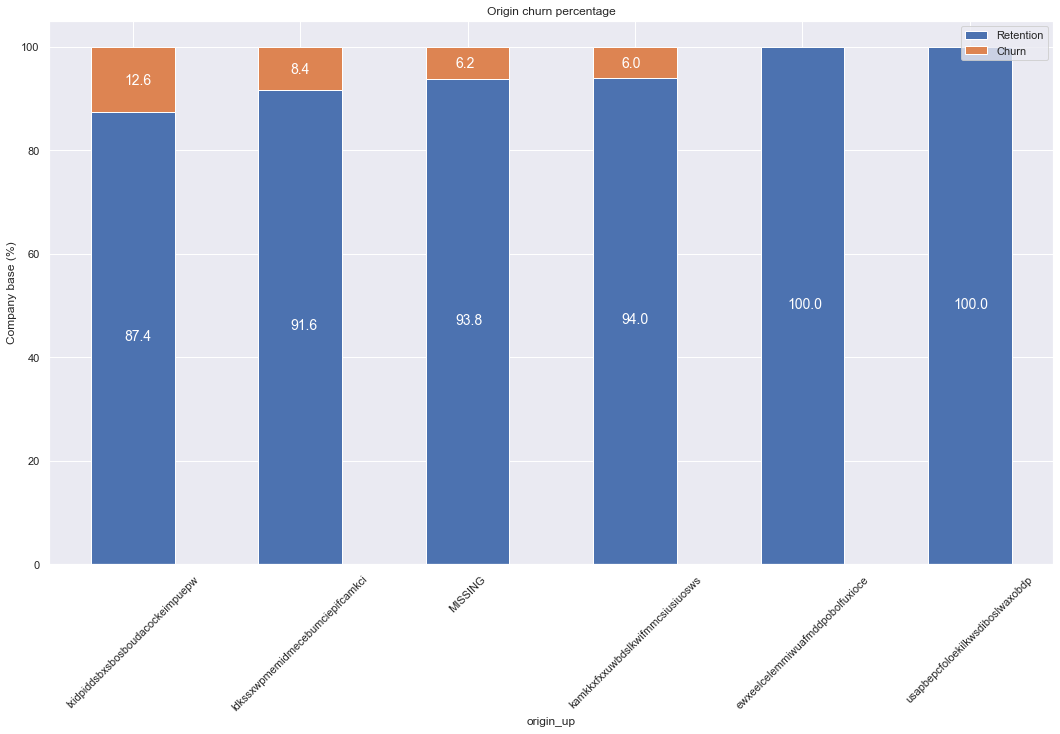

In [47]:
plot_stacked_bars(origin_churn,'Origin churn percentage',rot_=45)

If the value_counts() series for origin_up and this stacked plot is compared, it is seen that 2 out of these 6 categories have only 3 customers as a sum. This may not have any effect on the model, therefore, we could drop these columns to make it easier for the model to decide the dominating categories. 

In [48]:
channel = df[['id','channel_sales','churn']]
channel= channel.groupby([channel['channel_sales'],channel['churn']])['id'].count().unstack(level=1).fillna(0)
channel_churn = (channel.div(channel.sum(axis=1),axis=0)*100).sort_values(by=[1], ascending=False)

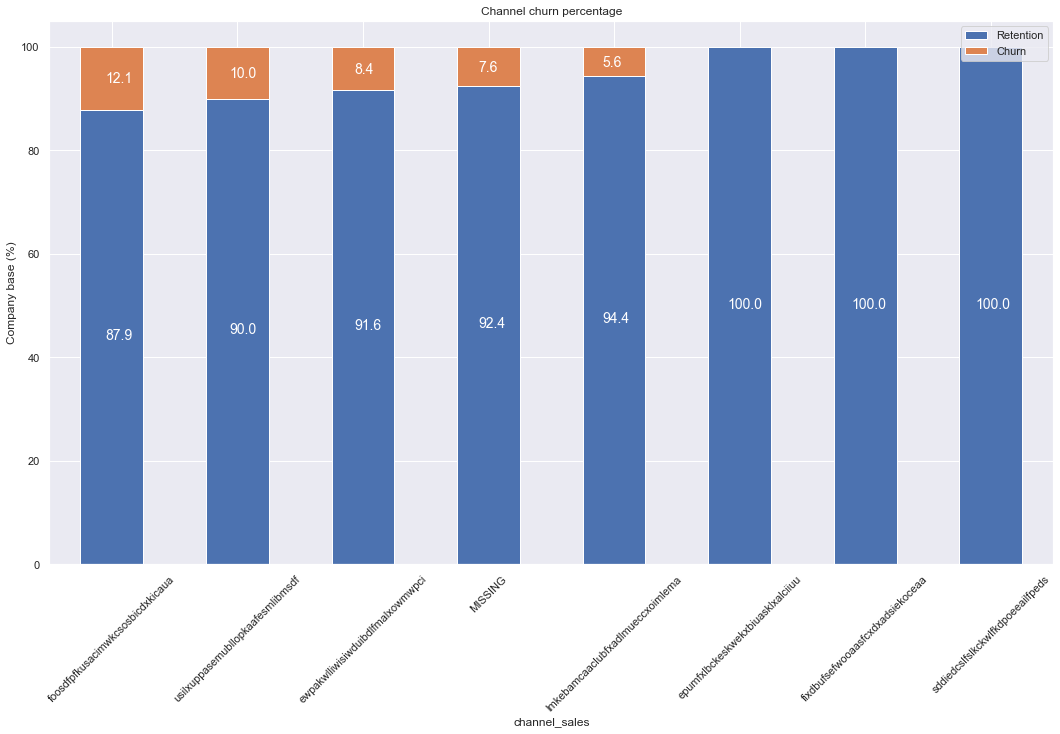

In [49]:
plot_stacked_bars(channel_churn,'Channel churn percentage',rot_=45)

Similarly, for channel sales and the number of customers belonging to 3 categories are infinitesimal if the entire dataset is considered collectively.

Categorical variables are created in a machine learning model for obvious reasons- classification. Here, we could use one-hot encoding to classify the channel sales 

In [50]:
df = pd.get_dummies(df,columns=['origin_up'],prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING','origin_up_usapbepcfoloekilkwsdiboslwaxobdp','origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_fix_max_diff,off_peak_mid_peak_max_fix,tenure,months_since_modif,months_active,months_to_end,months_since_renew,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,8.145775,44.26693,3,2,30,5,6,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.000000,44.44471,7,76,76,7,4,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.000000,44.44471,6,68,68,3,8,1,0,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,44.44471,6,69,69,2,9,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,8.145775,24.43733,6,71,71,2,9,1,0,0


In [51]:
df = pd.get_dummies(df,columns=['channel_sales'],prefix='channel_sales')
df = df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds','channel_sales_epumfxlbckeskwekxbiuasklxalciiuu','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_to_end,months_since_renew,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,5,6,0,0,1,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,7,4,1,0,0,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,3,8,1,0,0,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,2,9,1,0,0,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,2,9,1,0,0,1,0,0,0,0


In [52]:
df.describe()


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_to_end,months_since_renew,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,...,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085,...,6.393153,4.910305,0.294009,0.215543,0.485861,0.255050,0.061143,0.462376,0.126190,0.094146
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140,...,3.512845,3.795950,0.455612,0.411212,0.499817,0.435904,0.239601,0.498599,0.332074,0.292042
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,...,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378,...,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378,...,9.000000,8.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,...,17.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The standard deviation and IQE are in exponential values. It could be transformed to logarithmic values or square roots for ease in prediction. However, 'logarithmic transformation can be used for "positively skewed" distribution'.

# Skewness of data

The standard deviation is of more significance in this specific analysis because it is of prime importance for Kernel density estimate. Hence, the following transformation.

In [53]:
#Using numpy's log10 method
df["cons_12m"] = np.log10(df["cons_12m"]+1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)


In [54]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

In [55]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,4.223945,0.778978,2.264801,2.962162,1.784733,0.966450,1.517233,0.137282,0.050488,43.130085
std,0.884545,1.716828,1.769266,0.683612,1.584972,5.108355,0.571489,0.024623,0.049037,4.486140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149742,0.000000,2.899821,3.046733,2.498311,0.000000,1.296665,0.143166,0.084138,44.311378
75%,4.610287,0.000000,3.529430,3.380803,3.242293,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


C:\Users\NAMEERA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cons_12m', ylabel='Density'>

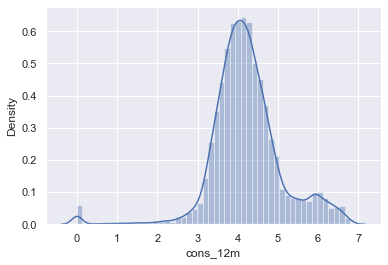

In [56]:
#plotting distplot for consumption and forecast
sns.distplot(df['cons_12m'])

C:\Users\NAMEERA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='forecast_cons_12m', ylabel='Density'>

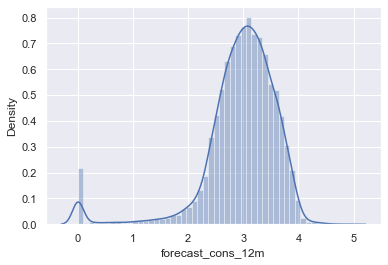

In [57]:
sns.distplot(df['forecast_cons_12m'])

# Correlation 

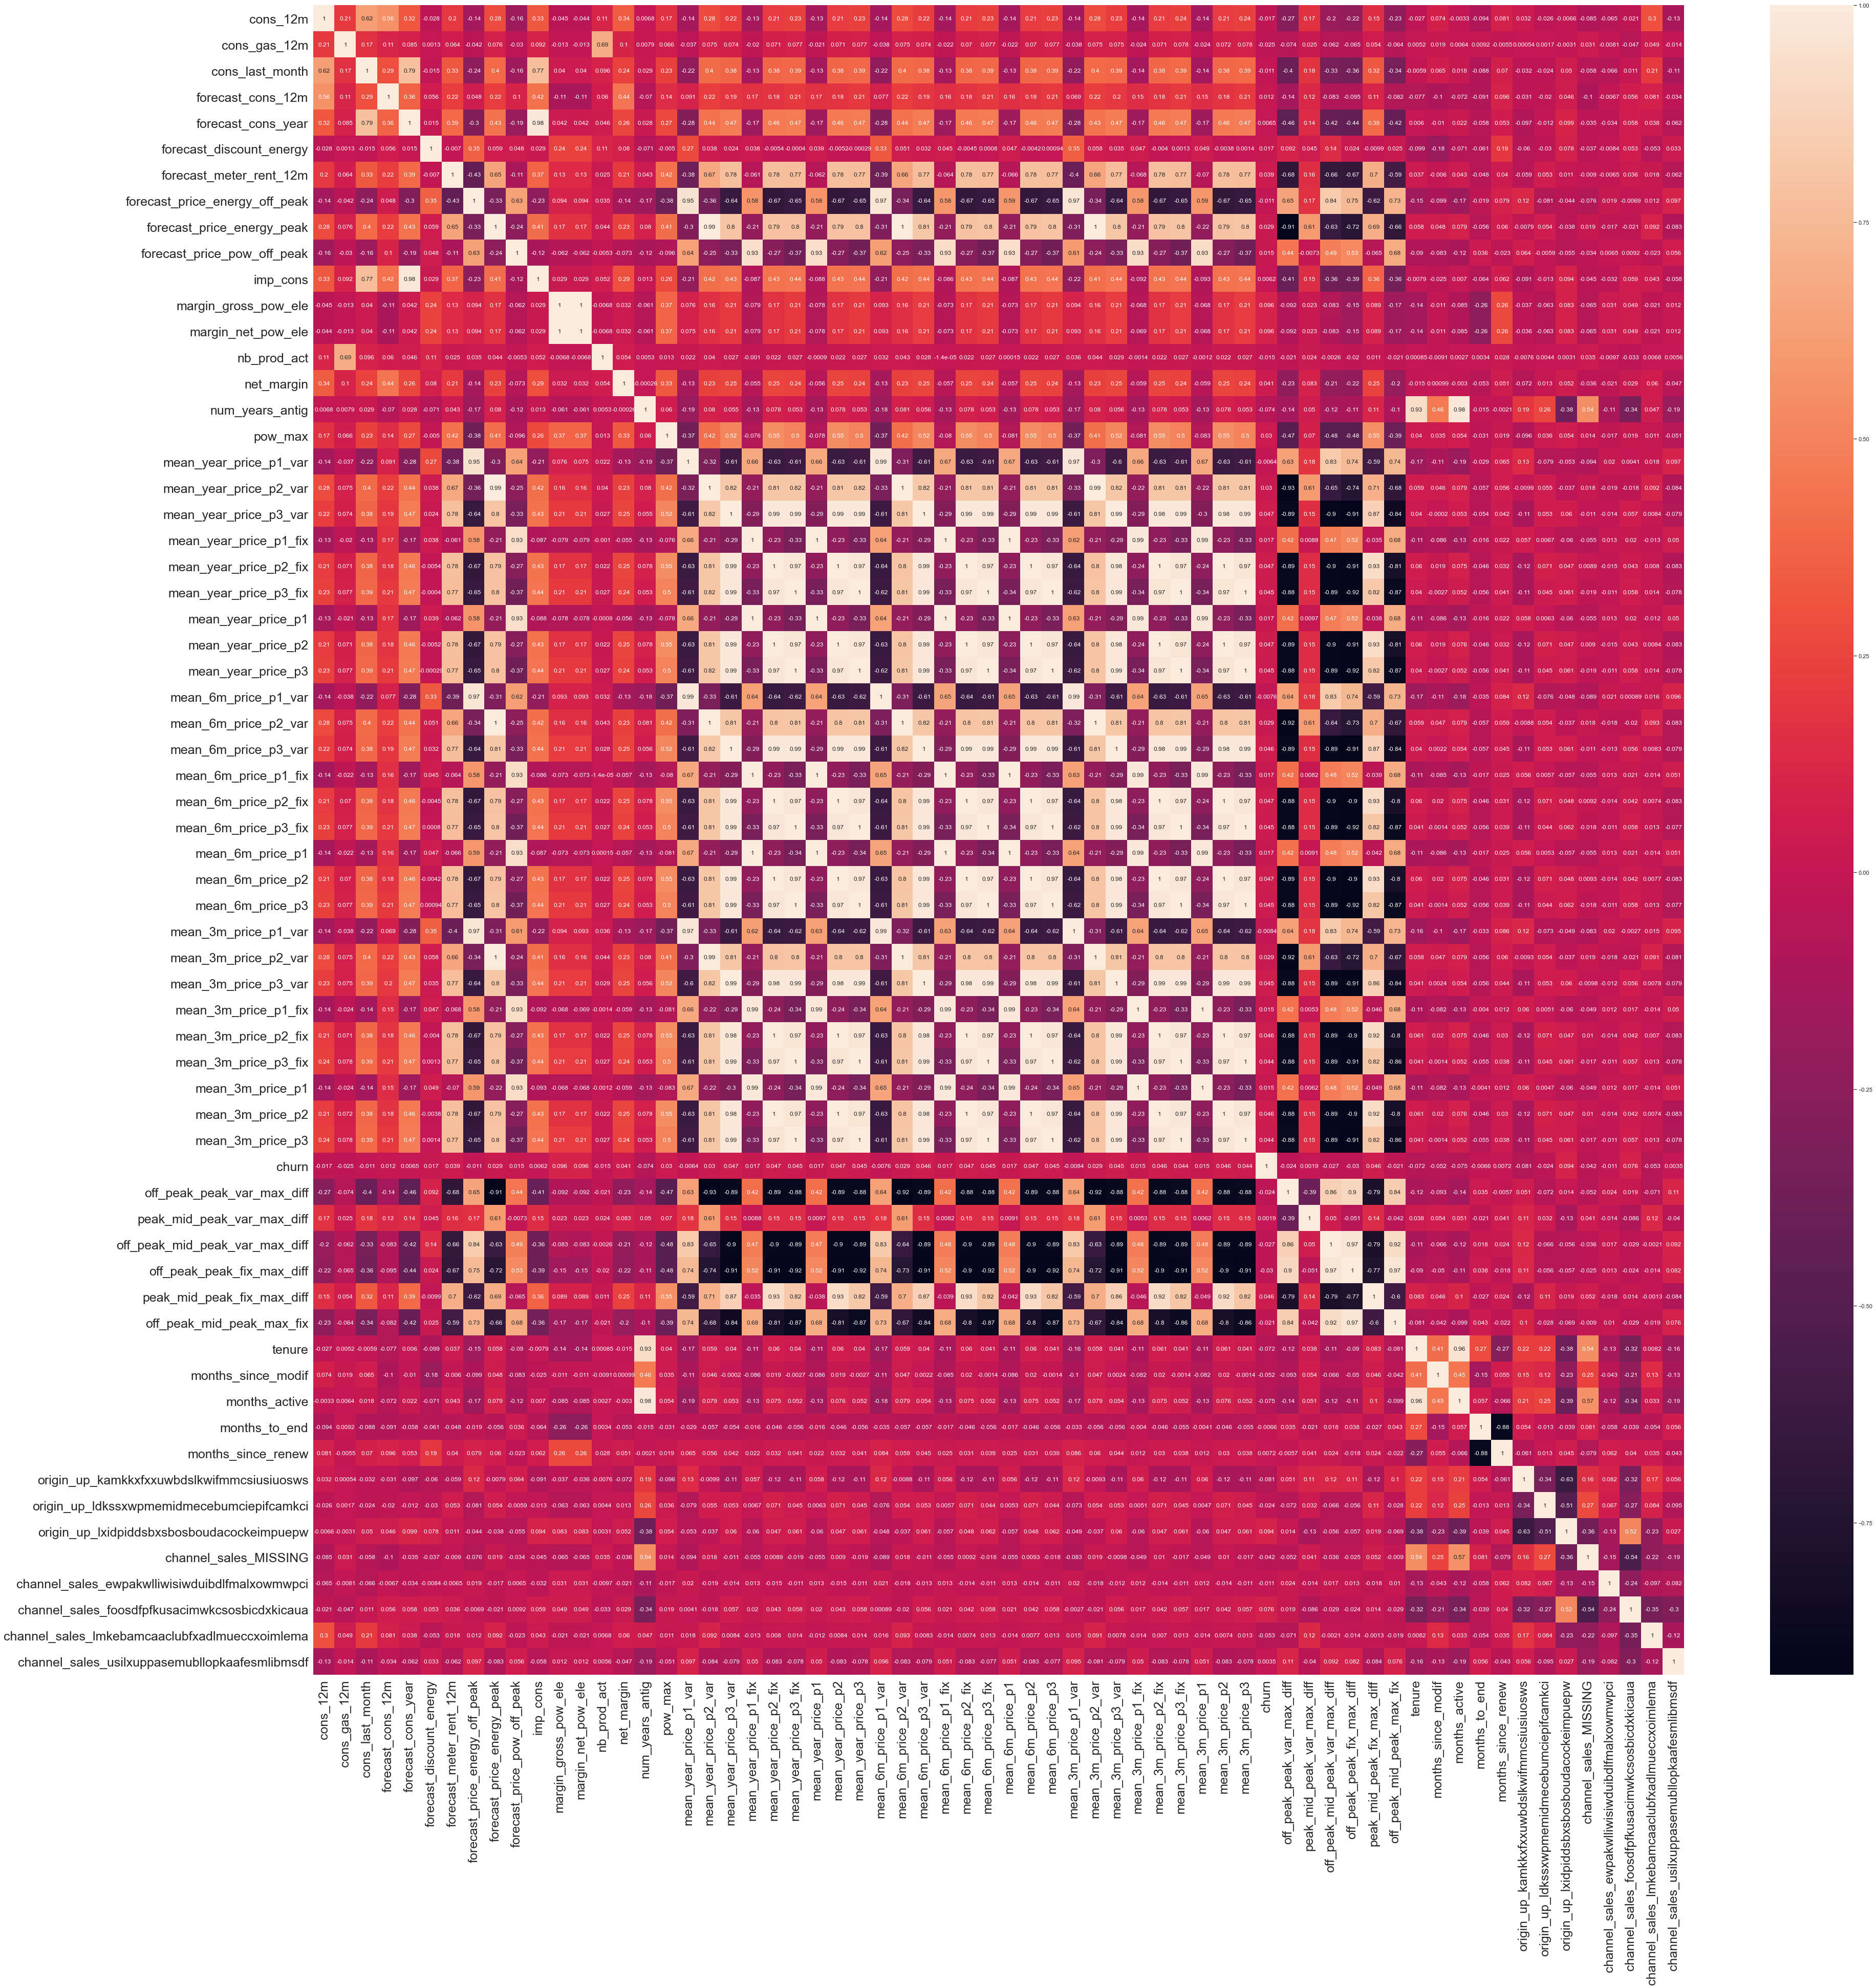

In [58]:
correlation_fe = df.corr()
plt.figure(figsize=(60,60))
sns.heatmap(correlation_fe,xticklabels=correlation_fe.columns.values, yticklabels=correlation_fe.columns.values, annot = True,annot_kws={'size':'12'})
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [59]:
#To find positive or negative correlation
corr_pos_beg = df.drop(columns=['id','churn'])
correlations = corr_pos_beg.corrwith(df.churn)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)
print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)

Most Positive Correlations: 
 margin_net_pow_ele                                0.095780
margin_gross_pow_ele                              0.095733
origin_up_lxidpiddsbxsbosboudacockeimpuepw        0.094158
channel_sales_foosdfpfkusacimwkcsosbicdxkicaua    0.075991
mean_year_price_p2_fix                            0.047224
mean_year_price_p2                                0.047188
mean_6m_price_p2_fix                              0.047067
mean_6m_price_p2                                  0.047030
mean_year_price_p3_var                            0.046528
mean_6m_price_p3_var                              0.046225
peak_mid_peak_fix_max_diff                        0.045780
mean_3m_price_p2_fix                              0.045755
mean_3m_price_p2                                  0.045724
mean_3m_price_p3_var                              0.045218
mean_year_price_p3                                0.044835
mean_year_price_p3_fix                            0.044825
mean_6m_price_p3          

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

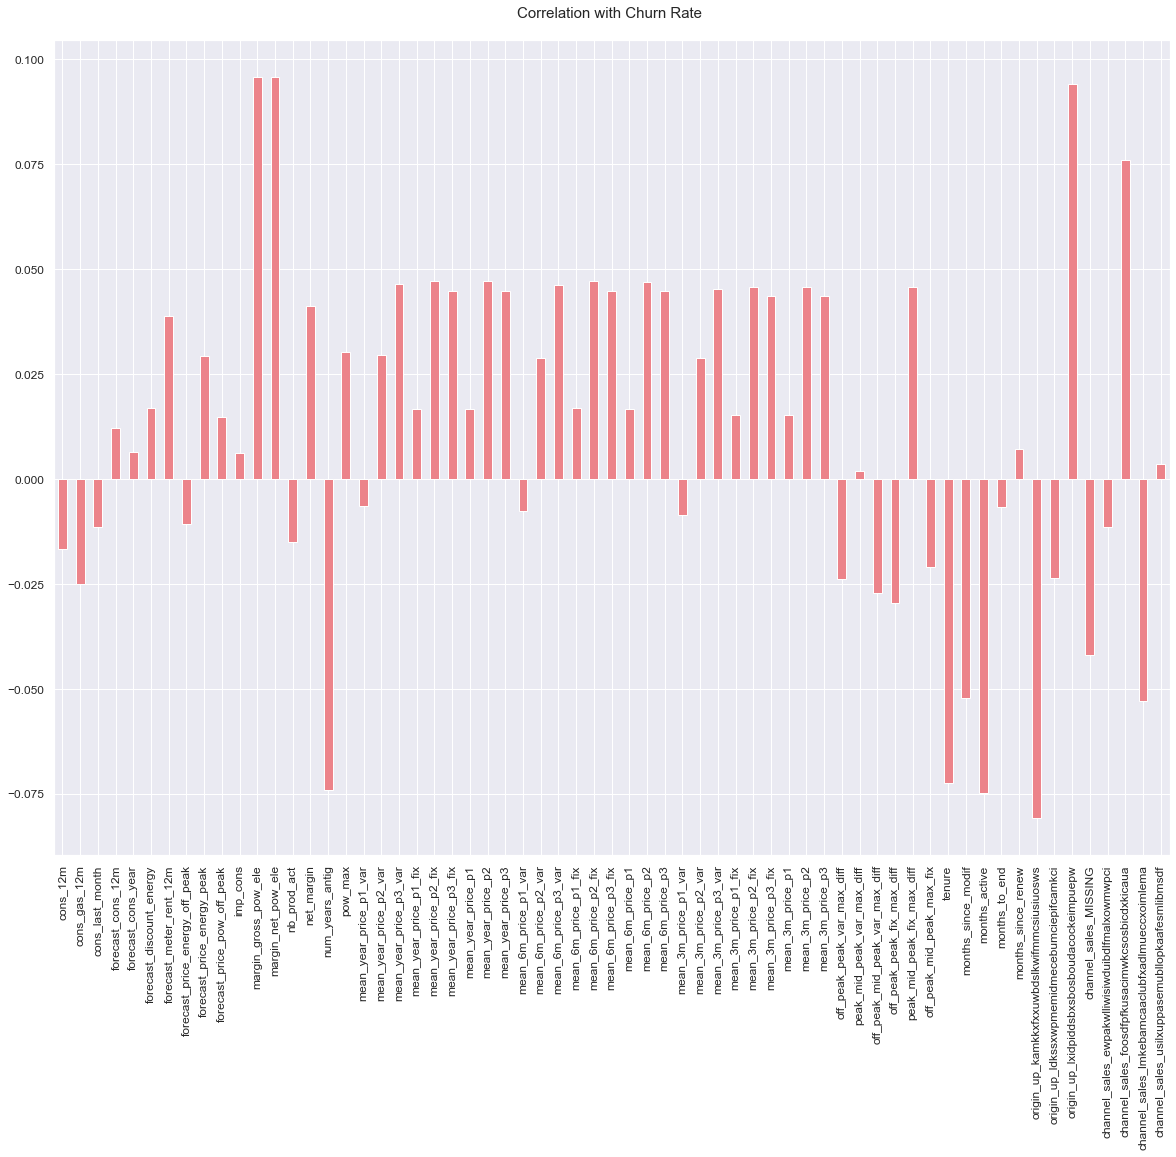

In [60]:
#plotting the correlation
correlations.plot.bar(figsize= (20,15),fontsize = 12, color = '#ec838a',
        rot = 90, grid = True)
plt.title('Correlation with Churn Rate \n',horizontalalignment="center", fontstyle = "normal", fontsize = "15", fontfamily = "sans-serif")

<AxesSubplot:>

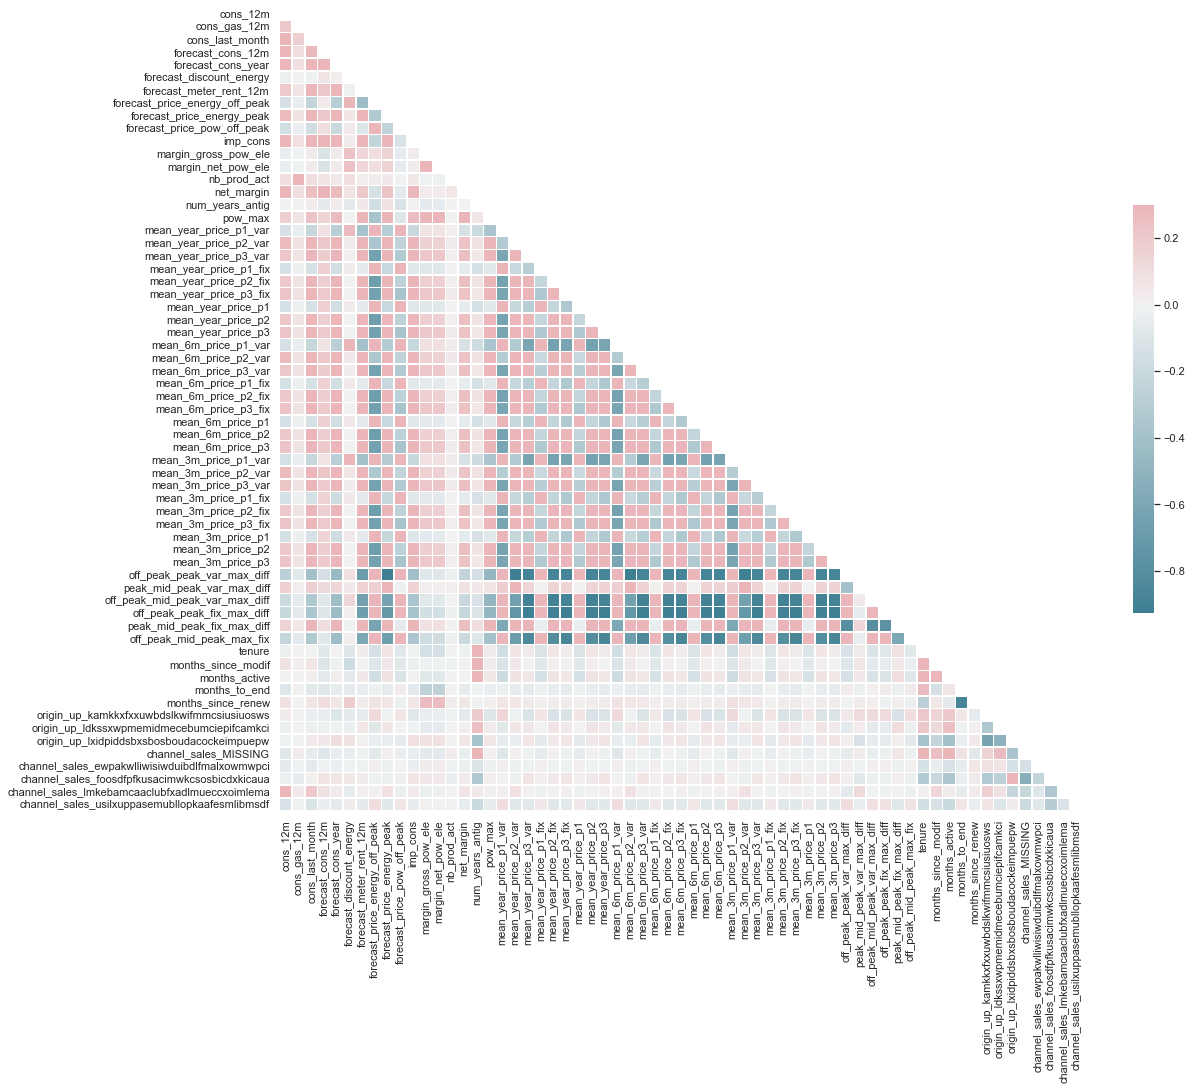

In [61]:
#Another heatmap 
sns.set(style='white')
corr = corr_pos_beg.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlation amidst price sensitivities and churn is bleak. 

In [62]:
df.dtypes

id                                                 object
cons_12m                                          float64
cons_gas_12m                                      float64
cons_last_month                                   float64
forecast_cons_12m                                 float64
                                                   ...   
channel_sales_MISSING                               uint8
channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci      uint8
channel_sales_foosdfpfkusacimwkcsosbicdxkicaua      uint8
channel_sales_lmkebamcaaclubfxadlmueccxoimlema      uint8
channel_sales_usilxuppasemubllopkaafesmlibmsdf      uint8
Length: 66, dtype: object

In [63]:
#to calculate variance inflation factor
vif_data = df[['cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'mean_year_price_p1_var',
       'mean_year_price_p2_var', 'mean_year_price_p3_var',
       'mean_year_price_p1_fix', 'mean_year_price_p2_fix',
       'mean_year_price_p3_fix', 'mean_year_price_p1', 'mean_year_price_p2',
       'mean_year_price_p3', 'mean_6m_price_p1_var', 'mean_6m_price_p2_var',
       'mean_6m_price_p3_var', 'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix',
       'mean_6m_price_p3_fix', 'mean_6m_price_p1', 'mean_6m_price_p2',
       'mean_6m_price_p3', 'mean_3m_price_p1_var', 'mean_3m_price_p2_var',
       'mean_3m_price_p3_var', 'mean_3m_price_p1_fix', 'mean_3m_price_p2_fix',
       'mean_3m_price_p3_fix', 'mean_3m_price_p1', 'mean_3m_price_p2',
       'mean_3m_price_p3', 'off_peak_peak_var_max_diff',
       'peak_mid_peak_var_max_diff', 'off_peak_mid_peak_var_max_diff',
       'off_peak_peak_fix_max_diff', 'peak_mid_peak_fix_max_diff',
       'off_peak_mid_peak_max_fix', 'tenure', 'months_since_modif',
       'months_active', 'months_to_end', 'months_since_renew',
       'origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'origin_up_ldkssxwpmemidmecebumciepifcamkci',
       'origin_up_lxidpiddsbxsbosboudacockeimpuepw', 'channel_sales_MISSING',
       'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_sales_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
       'channel_sales_usilxuppasemubllopkaafesmlibmsdf']]

In [64]:
vif_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 64 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   cons_12m                                        14605 non-null  float64
 1   cons_gas_12m                                    14605 non-null  float64
 2   cons_last_month                                 14605 non-null  float64
 3   forecast_cons_12m                               14605 non-null  float64
 4   forecast_cons_year                              14605 non-null  float64
 5   forecast_discount_energy                        14605 non-null  float64
 6   forecast_meter_rent_12m                         14605 non-null  float64
 7   forecast_price_energy_off_peak                  14605 non-null  float64
 8   forecast_price_energy_peak                      14605 non-null  float64
 9   forecast_price_pow_off_peak            

In [65]:
gas = {'t':1,'f':0}
vif_data['has_gas']= vif_data['has_gas'].map(gas)

<ipython-input-65-00d6a0c4ffb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_data['has_gas']= vif_data['has_gas'].map(gas)


In [66]:
vif_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 64 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   cons_12m                                        14605 non-null  float64
 1   cons_gas_12m                                    14605 non-null  float64
 2   cons_last_month                                 14605 non-null  float64
 3   forecast_cons_12m                               14605 non-null  float64
 4   forecast_cons_year                              14605 non-null  float64
 5   forecast_discount_energy                        14605 non-null  float64
 6   forecast_meter_rent_12m                         14605 non-null  float64
 7   forecast_price_energy_off_peak                  14605 non-null  float64
 8   forecast_price_energy_peak                      14605 non-null  float64
 9   forecast_price_pow_off_peak            

In [67]:
vif_data.isnull().sum()

cons_12m                                          0
cons_gas_12m                                      0
cons_last_month                                   0
forecast_cons_12m                                 0
forecast_cons_year                                0
                                                 ..
channel_sales_MISSING                             0
channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci    0
channel_sales_foosdfpfkusacimwkcsosbicdxkicaua    0
channel_sales_lmkebamcaaclubfxadlmueccxoimlema    0
channel_sales_usilxuppasemubllopkaafesmlibmsdf    0
Length: 64, dtype: int64

In [68]:
# To check multicollinearity 
def calc_vif(X):
# Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])]
    return(vif)
vif_table = calc_vif(vif_data)

C:\Users\NAMEERA\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [69]:
vif_table[vif_table['VIF']>=14000]

,variables,VIF
12,margin_gross_pow_ele,1.450003e+04
13,margin_net_pow_ele,1.449144e+04
18,mean_year_price_p1_var,inf
19,mean_year_price_p2_var,inf
20,mean_year_price_p3_var,inf
21,mean_year_price_p1_fix,inf
22,mean_year_price_p2_fix,inf
23,mean_year_price_p3_fix,inf
24,mean_year_price_p1,inf
25,mean_year_price_p2,inf


In [70]:
vif_table

,variables,VIF
0,cons_12m,89.194204
1,cons_gas_12m,11.107624
2,cons_last_month,15.710530
3,forecast_cons_12m,64.927899
4,forecast_cons_year,113.119905
...,...,...
59,channel_sales_MISSING,95.865510
60,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,22.854420
61,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,170.189480
62,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,47.914701


In [71]:
df.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'mean_year_price_p1_var',
       'mean_year_price_p2_var', 'mean_year_price_p3_var',
       'mean_year_price_p1_fix', 'mean_year_price_p2_fix',
       'mean_year_price_p3_fix', 'mean_year_price_p1', 'mean_year_price_p2',
       'mean_year_price_p3', 'mean_6m_price_p1_var', 'mean_6m_price_p2_var',
       'mean_6m_price_p3_var', 'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix',
       'mean_6m_price_p3_fix', 'mean_6m_price_p1', 'mean_6m_price_p2',
       'mean_6m_price_p3', 'mean_3m_price_p1_var', 'mean_3m_price_p2_var',
       'mean_3m_price_p3_var', 'mean_3m_price_p1_fix', 'mean_

The infinite values for VIF is due to the following: 
- If it shows a perfect correlation between two independent variables. In the case of perfect correlation, we get R2 =1, which lead to 1/(1-R2) infinity. To solve this problem we need to drop one of the variables from the dataset which is causing this perfect multicollinearity.
- multicollinearity can also occur when you use dummy variables to handle discrete independent variables and if you are not careful and include the default values as well.

In [72]:
vif_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 64 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   cons_12m                                        14605 non-null  float64
 1   cons_gas_12m                                    14605 non-null  float64
 2   cons_last_month                                 14605 non-null  float64
 3   forecast_cons_12m                               14605 non-null  float64
 4   forecast_cons_year                              14605 non-null  float64
 5   forecast_discount_energy                        14605 non-null  float64
 6   forecast_meter_rent_12m                         14605 non-null  float64
 7   forecast_price_energy_off_peak                  14605 non-null  float64
 8   forecast_price_energy_peak                      14605 non-null  float64
 9   forecast_price_pow_off_peak            

In [73]:
#dropping varibles with infinite values
calc_vif(vif_data)

C:\Users\NAMEERA\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,cons_12m,89.194204
1,cons_gas_12m,11.107624
2,cons_last_month,15.710530
3,forecast_cons_12m,64.927899
4,forecast_cons_year,113.119905
...,...,...
59,channel_sales_MISSING,95.865510
60,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,22.854420
61,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,170.189480
62,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,47.914701


In [74]:
vif_data = vif_data.drop(['mean_year_price_p2_var', 'mean_year_price_p3_var',
       'mean_year_price_p1_fix', 'mean_year_price_p2_fix',
       'mean_year_price_p3_fix'],axis=1)
calc_vif(vif_data)

C:\Users\NAMEERA\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,cons_12m,8.913624e+01
1,cons_gas_12m,1.110705e+01
2,cons_last_month,1.570658e+01
3,forecast_cons_12m,6.489612e+01
4,forecast_cons_year,1.128358e+02
5,forecast_discount_energy,2.816080e+00
6,forecast_meter_rent_12m,2.271491e+01
7,forecast_price_energy_off_peak,2.316566e+03
8,forecast_price_energy_peak,4.599435e+02
9,forecast_price_pow_off_peak,2.857975e+03


In [75]:
vif_data = vif_data.drop(columns='mean_year_price_p1_var')
calc_vif(vif_data)


C:\Users\NAMEERA\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,cons_12m,8.913533e+01
1,cons_gas_12m,1.110693e+01
2,cons_last_month,1.570403e+01
3,forecast_cons_12m,6.476025e+01
4,forecast_cons_year,1.127916e+02
5,forecast_discount_energy,2.778170e+00
6,forecast_meter_rent_12m,2.271374e+01
7,forecast_price_energy_off_peak,2.305922e+03
8,forecast_price_energy_peak,4.598557e+02
9,forecast_price_pow_off_peak,2.845023e+03


In [76]:
vif_data = vif_data.drop(['mean_year_price_p1',
       'mean_year_price_p2', 'mean_year_price_p3', 'mean_6m_price_p1_var',
       'mean_6m_price_p2_var', 'mean_6m_price_p3_var', 'mean_6m_price_p1_fix',
       'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix', 'mean_6m_price_p1',
       'mean_6m_price_p2', 'mean_6m_price_p3', 'mean_3m_price_p1_var',
       'mean_3m_price_p2_var', 'mean_3m_price_p3_var', 'mean_3m_price_p1_fix',
       'mean_3m_price_p2_fix', 'mean_3m_price_p3_fix', 'mean_3m_price_p1',
       'mean_3m_price_p2', 'mean_3m_price_p3'],axis=1)
calc_vif(vif_data)

,variables,VIF
0,cons_12m,87.784066
1,cons_gas_12m,11.092147
2,cons_last_month,15.555417
3,forecast_cons_12m,59.580875
4,forecast_cons_year,108.503541
5,forecast_discount_energy,2.406914
6,forecast_meter_rent_12m,21.052951
7,forecast_price_energy_off_peak,877.000812
8,forecast_price_energy_peak,113.021431
9,forecast_price_pow_off_peak,1260.082973


By dropping the features that generated exorbitant values, the multicollinearity of the other variables has reduced. Although these are not reasonable, it captures the essence of the data set that cannot be compromised

In [77]:
vif_data.columns

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'off_peak_peak_var_max_diff', 'peak_mid_peak_var_max_diff',
       'off_peak_mid_peak_var_max_diff', 'off_peak_peak_fix_max_diff',
       'peak_mid_peak_fix_max_diff', 'off_peak_mid_peak_max_fix', 'tenure',
       'months_since_modif', 'months_active', 'months_to_end',
       'months_since_renew', 'origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'origin_up_ldkssxwpmemidmecebumciepifcamkci',
       'origin_up_lxidpiddsbxsbosboudacockeimpuepw', 'channel_sales_MISSING',
       'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_sales_foosdfpfkusacimwkcsosbicdxki

In [78]:
df = df[['id','churn','cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'off_peak_peak_var_max_diff', 'peak_mid_peak_var_max_diff',
       'off_peak_mid_peak_var_max_diff', 'off_peak_peak_fix_max_diff',
       'peak_mid_peak_fix_max_diff', 'off_peak_mid_peak_max_fix', 'tenure',
       'months_since_modif', 'months_active', 'months_to_end',
       'months_since_renew', 'origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'origin_up_ldkssxwpmemidmecebumciepifcamkci',
       'origin_up_lxidpiddsbxsbosboudacockeimpuepw', 'channel_sales_MISSING',
       'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_sales_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
       'channel_sales_usilxuppasemubllopkaafesmlibmsdf']]

# Modelling

In [79]:
identity_encode = df['id']
df = df.drop(columns = ['id'])

#convert the rest of the dataset into dummy variables
df= pd.get_dummies(df)

#rejoin id to dataset
df= pd.concat([df,identity_encode],axis=1)

In [80]:
#Split the dataset into dependent and independent variables 
X= df.drop(columns='churn')
y = df['churn']

In [81]:
#splitting the dataset using train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (11684, 39)
Number transactions y_train dataset:  (11684,)
Number transactions X_test dataset:  (2921, 39)
Number transactions y_test dataset:  (2921,)


In [82]:
#remove identifiers since these are string objects
train_identity_2 = X_train['id']
X_train = X_train.drop(columns = ['id'])
test_identity_2 = X_test['id']
X_test = X_test.drop(columns = ['id'])

In [83]:
#modelling 
select.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [84]:
from sklearn.metrics import fbeta_score
#prediction
prediction = select.predict(X_test)

#confusion matrix and scores
#RFC
ypred = prediction
model = select
#ravel() used for a flattenned contiguous array
tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()

print ('Confusion Matrix:')

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")
print('\nAccuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
print("Overall f1-score:", f1_score(y_test, ypred))
print("Fbeta_score:",fbeta_score(y_test, ypred, beta=2.0))
auc = roc_auc_score(y_test,ypred)
plt.show()

Confusion Matrix:
True positives: 25
False positives: 3
True negatives: 2634
False negatives: 259


Accuracy: 0.9103046901745977
Overall Precision: 0.8928571428571429
Overall Recall: 0.0880281690140845
Overall f1-score: 0.16025641025641024
Fbeta_score: 0.10738831615120274


Although the accuracy of the model is about 91%, it is always not the metric we are sought after. The test set has a number of 2921 out of which the model has predicted True negatives (churn = 0) of 2634, that is a very good number. However, the false negatives are about 259; this shouldn't be the case (i.e) false negatives should be as close to 0 as possible, hence paving way for parameter tuning. Also pointing out the fact that the recall rate is very low, further proving the point. 

Overall, the precison of the model is at 89.2% which is a good number but could be improved. The point of concern is that the model predicts the customers who wouldn't churn with a higher precision than the customers who would (which is the point of interest here).
- precision increased by 3% in comparison to the contrary (Dropped columns after inspecting VIF)

# Feature importance 

In [85]:
#feature importance histogram
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': select.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


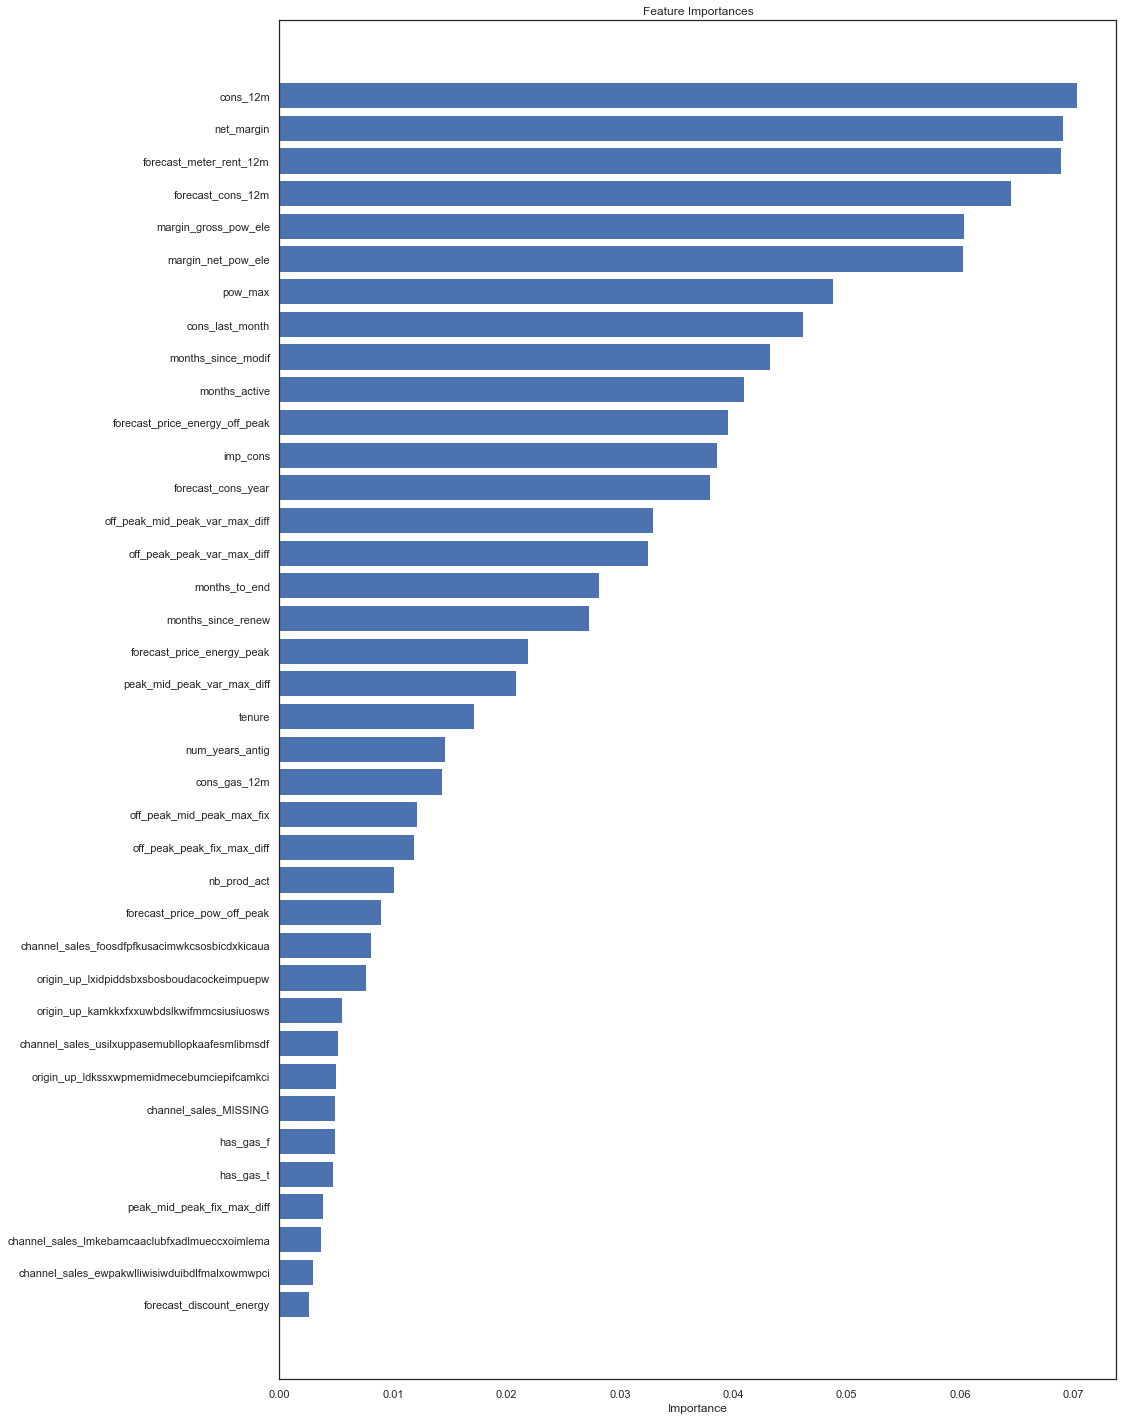

In [86]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

The highest drivers of churn from the histogram:
   - electricity consumption over the past 12 months 
   - and net margin
   - forecast meter rent for the following 12 months
   - other independent features seem to be of more importance but price not being one of those
    

# Model improvement 

Hyperparameter tuning 

In [87]:
ypred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [88]:
proba_predictions = select.predict_proba(X_test)[:,1]

In [89]:
proba_predictions

array([0.114, 0.035, 0.234, ..., 0.049, 0.057, 0.025])

In [90]:
X_test= X_test.reset_index()
X_test

,index,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,has_gas_f,has_gas_t
0,7414,4.546654,0.000000,3.615740,2.323809,0.000000,0.0,1.286905,0.140621,0.000000,...,1,0,0,0,0,1,0,0,1,0
1,8350,4.465189,0.000000,0.000000,3.631883,0.000000,0.0,1.797060,0.143478,0.000000,...,0,1,0,1,0,0,0,0,1,0
2,12672,4.506140,0.000000,3.547529,3.395585,3.484585,0.0,2.232691,0.114588,0.097701,...,0,0,1,0,0,1,0,0,1,0
3,13201,3.672744,4.230423,0.000000,2.853583,0.000000,0.0,1.290480,0.147506,0.000000,...,0,0,1,0,0,1,0,0,0,1
4,1415,4.270003,0.000000,0.000000,3.302666,0.000000,0.0,2.114778,0.115360,0.100243,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2056,4.281942,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000600,0.000000,...,0,0,1,1,0,0,0,0,1,0
2917,3000,4.556664,4.703807,3.615845,3.569003,3.615845,0.0,2.166667,0.115174,0.098837,...,0,0,1,0,0,1,0,0,0,1
2918,4121,3.413970,0.000000,2.930440,2.460763,2.930440,0.0,1.238548,0.165793,0.088539,...,0,1,0,1,0,0,0,0,1,0
2919,3998,5.511454,0.000000,4.743518,3.232460,3.736635,0.0,1.985382,0.116509,0.101397,...,0,0,1,0,0,1,0,0,1,0


In [91]:
X_test.head()

,index,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,has_gas_f,has_gas_t
0,7414,4.546654,0.000000,3.615740,2.323809,0.000000,0.0,1.286905,0.140621,0.000000,...,1,0,0,0,0,1,0,0,1,0
1,8350,4.465189,0.000000,0.000000,3.631883,0.000000,0.0,1.797060,0.143478,0.000000,...,0,1,0,1,0,0,0,0,1,0
2,12672,4.506140,0.000000,3.547529,3.395585,3.484585,0.0,2.232691,0.114588,0.097701,...,0,0,1,0,0,1,0,0,1,0
3,13201,3.672744,4.230423,0.000000,2.853583,0.000000,0.0,1.290480,0.147506,0.000000,...,0,0,1,0,0,1,0,0,0,1
4,1415,4.270003,0.000000,0.000000,3.302666,0.000000,0.0,2.114778,0.115360,0.100243,...,0,0,1,0,0,1,0,0,1,0


In [92]:

fpr, tpr, thresholds = roc_curve(y_test, proba_predictions)

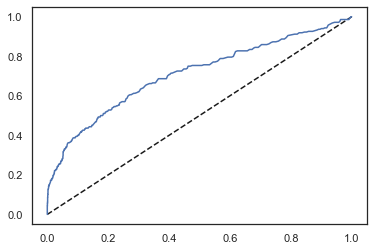

In [93]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Random Forest Classifier')

In [94]:
roc_auc_score(y_test, proba_predictions)

0.7094896836460554

The model would be able to predict the customer's who've churned by 70.2% which is an average score. 

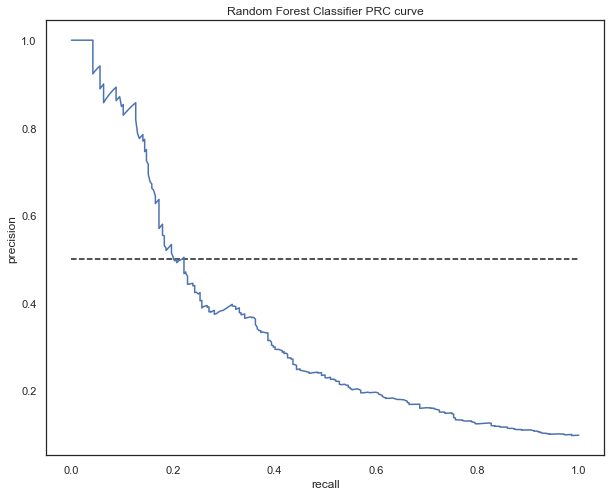

In [95]:
precision, recall, thresholds = precision_recall_curve(y_test, proba_predictions)

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5,0.5],'k--')
plt.plot(recall, precision, label = 'RFC')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Random Forest Classifier PRC curve')
plt.show()

In [96]:
print(auc(recall,precision))

TypeError: 'numpy.float64' object is not callable

Another result proving that the high accuracy of the model is of no significance here since the data provided is highly imbalanced leading to a very poor recall. This could also be a consequence of the model used. Would need more experimentation to build a better machine-learning model.

# XGBoost classifier 

In [ ]:
X_train.describe()

In [ ]:
X_train_xgb,X_test_xgb,y_train_xgb,y_test_xgb = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
print("Number transactions X_train dataset: ", X_train_xgb.shape)
print("Number transactions y_train dataset: ", y_train_xgb.shape)
print("Number transactions X_test dataset: ", X_test_xgb.shape)
print("Number transactions y_test dataset: ", y_test_xgb.shape)

In [ ]:
#remove identifiers since these are string objects
train_identity_3 = X_train_xgb['id']
X_train_xgb = X_train_xgb.drop(columns = ['id'])
test_identity_3 = X_test_xgb['id']
X_test_xgb = X_test_xgb.drop(columns = ['id'])

In [ ]:
xgbc = XGBClassifier() 

In [ ]:
xgbc.fit(X_train_xgb,y_train_xgb)

In [ ]:

#prediction
prediction_xgb = xgbc.predict(X_test_xgb)

#confusion matrix and scores
#RFC
ypred = prediction_xgb
model = xgbc
#ravel() used for a flattenned contiguous array
tn, fp, fn, tp = confusion_matrix(y_test_xgb, ypred).ravel()

print ('Confusion Matrix:')

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")
print('\nAccuracy:', accuracy_score(y_test_xgb, ypred))
print("Overall Precision:",precision_score(y_test_xgb, ypred))
print("Overall Recall:",recall_score(y_test_xgb, ypred))
print("Overall f1-score:", f1_score(y_test_xgb, ypred))
auc = roc_auc_score(y_test_xgb,ypred)
plt.show()


increase in recall but decrease in precision

In [ ]:
proba_predictions_xgb = xgbc.predict_proba(X_test_xgb)[:,1]

In [ ]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, proba_predictions_xgb)

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5,0.5],'k--')
plt.plot(recall, precision, label = 'XGB')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('XGBoost PRC curve')
plt.show()

Learning from unbalanced data may be an unruly task since the minority class is infinitesimal in comparison.

After trial with oversampling and undersampling techniques with random forest classifier technique and XGBoost classifier, the model seems to be at its prime when it is used as a standalone. 
- With increase in model complexity, the metrics generated plummeting results. 
- Oversampling and undersampling with random forest classifier had worse effects.
- Logistic regression is a model too simple for this dataset. 

Hence, choosing random forest classifier is far more favourable with a little more experimentation in the hyperparameter tuning. 

# Saving prediction 

In [97]:
X_test.head()

,index,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,has_gas_f,has_gas_t
0,7414,4.546654,0.000000,3.615740,2.323809,0.000000,0.0,1.286905,0.140621,0.000000,...,1,0,0,0,0,1,0,0,1,0
1,8350,4.465189,0.000000,0.000000,3.631883,0.000000,0.0,1.797060,0.143478,0.000000,...,0,1,0,1,0,0,0,0,1,0
2,12672,4.506140,0.000000,3.547529,3.395585,3.484585,0.0,2.232691,0.114588,0.097701,...,0,0,1,0,0,1,0,0,1,0
3,13201,3.672744,4.230423,0.000000,2.853583,0.000000,0.0,1.290480,0.147506,0.000000,...,0,0,1,0,0,1,0,0,0,1
4,1415,4.270003,0.000000,0.000000,3.302666,0.000000,0.0,2.114778,0.115360,0.100243,...,0,0,1,0,0,1,0,0,1,0


In [98]:
X_test.drop(columns='index', inplace=True)

In [100]:
X_test['churn']= prediction.tolist()

In [101]:
X_test['churn_probability'] = proba_predictions.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')